# CNN method by Kaggle

## Libaries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image as mp_image
import seaborn as sns

%matplotlib inline

from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split


import os
import shutil


In [2]:
# Input training pictures

training_folder_name = 'train_images.csv'


classes  = np.load("class_names.npy", allow_pickle=True).item()
print(F"First class: {classes }") 
attributes = np.load("attributes.npy", allow_pickle=True)
print(F"Attributes shape: {attributes.shape}") 
print(attributes[0])

First class: {'001.Black_footed_Albatross': 1, '002.Laysan_Albatross': 2, '003.Sooty_Albatross': 3, '004.Groove_billed_Ani': 4, '005.Crested_Auklet': 5, '006.Least_Auklet': 6, '007.Parakeet_Auklet': 7, '008.Rhinoceros_Auklet': 8, '009.Brewer_Blackbird': 9, '010.Red_winged_Blackbird': 10, '011.Rusty_Blackbird': 11, '012.Yellow_headed_Blackbird': 12, '013.Bobolink': 13, '014.Indigo_Bunting': 14, '015.Lazuli_Bunting': 15, '016.Painted_Bunting': 16, '017.Cardinal': 17, '018.Spotted_Catbird': 18, '019.Gray_Catbird': 19, '020.Yellow_breasted_Chat': 20, '021.Eastern_Towhee': 21, '022.Chuck_will_Widow': 22, '023.Brandt_Cormorant': 23, '024.Red_faced_Cormorant': 24, '025.Pelagic_Cormorant': 25, '026.Bronzed_Cowbird': 26, '027.Shiny_Cowbird': 27, '028.Brown_Creeper': 28, '029.American_Crow': 29, '030.Fish_Crow': 30, '031.Black_billed_Cuckoo': 31, '032.Mangrove_Cuckoo': 32, '033.Yellow_billed_Cuckoo': 33, '034.Gray_crowned_Rosy_Finch': 34, '035.Purple_Finch': 35, '036.Northern_Flicker': 36, '037.

## Pytorch

In [3]:
import torch

print(torch.cuda.is_available())
print(torch.version.cuda)

import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


print("Libraries imported - ready to use PyTorch", torch.__version__)

True
12.1
Using device: cuda
Libraries imported - ready to use PyTorch 2.5.1+cu121


## Preperation images


In [11]:
from PIL import Image

def resize_image(src_image, size=(128,128), bg_color="white"): 
    from PIL import Image, ImageOps 
    src_image.thumbnail(size, Image.ANTIALIAS)
    new_image = Image.new("RGB", size, bg_color)
    new_image.paste(src_image, (int((size[0] - src_image.size[0]) / 2), int((size[1] - src_image.size[1]) / 2)))
    return new_image

In [13]:
CSV_PATH = "train_images.csv"

# Map waarin ALLE originele afbeeldingen staan
IMAGE_DIR = os.path.join("train_images", "train_images")

# Outputmap waar resized images in submappen komen
OUTPUT_DIR = "resized_training_data"

SIZE = (128, 128)

# Outputmap opnieuw maken
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)
os.makedirs(OUTPUT_DIR)

print("Resizing images...")

# CSV laden
df = pd.read_csv(CSV_PATH)

for idx, row in df.iterrows():
    img_name = os.path.basename(row["image_path"])
    label = str(row["label"])

    # bronbestand
    img_path = os.path.join(IMAGE_DIR, img_name)

    # maak labelmap
    label_folder = os.path.join(OUTPUT_DIR, label)
    os.makedirs(label_folder, exist_ok=True)

    # inladen + resizen
    try:
        img = Image.open(img_path).convert("RGB")
        img = img.resize(SIZE)

        save_path = os.path.join(label_folder, img_name)
        img.save(save_path)
    except Exception as e:
        print(f"Fout met {img_path}: {e}")

print("Done.")

Resizing images...
Done.


In [118]:
import torchvision
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import torch
import torchvision.transforms as transforms

def load_dataset(data_path, batch_size=50):
    # -----------------
    # Transforms
    # -----------------
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(128),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    val_transform = transforms.Compose([
        transforms.Resize((128,128)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    # -----------------
    # Load dataset
    # -----------------
    full_dataset = torchvision.datasets.ImageFolder(root=data_path)
    labels = [label for _, label in full_dataset.imgs]

    # -----------------
    # Stratified split
    # -----------------
    train_idx, val_idx = train_test_split(
        range(len(labels)),
        test_size=0.3,
        stratify=labels,
        random_state=42
    )

    # subsets maken
    train_dataset = Subset(full_dataset, train_idx)
    val_dataset = Subset(full_dataset, val_idx)

    # aparte transform toepassen via lambda
    train_dataset.dataset.transform = train_transform
    val_dataset.dataset.transform = val_transform

    # -----------------
    # DataLoaders
    # -----------------
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    return train_loader, val_loader


In [119]:
train_folder = 'resized_training_data'

# laad de dataset
train_loader, test_loader = load_dataset(train_folder)

batch_size = train_loader.batch_size
print("Data loaders ready to read", train_folder)


Data loaders ready to read resized_training_data


## Model

In [123]:
# -------------------------
# Imports
# -------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F

# -------------------------
# Model
# -------------------------
class Net(nn.Module):
    def __init__(self, num_classes=3):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 12, 3, 1, 1)
        self.conv2 = nn.Conv2d(12, 24, 3, 1, 1)
        self.pool = nn.MaxPool2d(2)
        self.drop = nn.Dropout2d(0.2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))  # flexibel
        self.fc = nn.Linear(24, num_classes)  # na adaptive pooling is het aantal features = 24

    def forward(self, x):
        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool(self.conv2(x)))
        x = self.drop(x)
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.fc(x)
        return x  # geen log_softmax, CrossEntropyLoss neemt dit over

# -------------------------
# Device en model
# -------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
num_classes = 3  # pas aan indien nodig
model = Net(num_classes=num_classes).to(device)

print(model)


Net(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout2d(p=0.2, inplace=False)
  (adaptive_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=24, out_features=3, bias=True)
)


In [126]:
def train_multi_task(model, device, train_loader, optimizer, epoch, criterion_class, criterion_attr, alpha=0.1):
    """
    Training loop voor multi-task model met classificatie + attributes.

    Parameters:
    - model: PyTorch model
    - device: "cuda" of "cpu"
    - train_loader: DataLoader die batches van (images, attrs, labels) levert
    - optimizer: optimizer
    - epoch: huidig epoch nummer (voor logging)
    - criterion_class: loss voor classificatie (bv CrossEntropyLoss)
    - criterion_attr: loss voor attributes (bv MSELoss)
    - alpha: gewicht van attribute loss tov class loss
    """
    model.train()
    train_loss = 0
    print("Epoch:", epoch)

    for batch_idx, (imgs, attrs, labels) in enumerate(train_loader):
        imgs, attrs, labels = imgs.to(device), attrs.to(device), labels.to(device)
        optimizer.zero_grad()
        pred_class, pred_attrs = model(imgs, attrs)
        loss_class = criterion_class(pred_class, labels)
        loss_attr = criterion_attr(pred_attrs, attrs)
        total_loss = loss_class + alpha * loss_attr
        total_loss.backward()
        optimizer.step()
        train_loss += total_loss.item()

        print(f'\tTraining batch {batch_idx + 1} Loss: {total_loss.item():.6f}')

    avg_loss = train_loss / (batch_idx + 1)
    print(f'Training set: Average loss: {avg_loss:.6f}')
    return avg_loss


In [128]:
def test(model, device, test_loader, loss_criteria):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_criteria(output, target).item()
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == target).sum().item()

    avg_loss = test_loss / batch_count
    accuracy = 100.0 * correct / len(test_loader.dataset)

    print(f'Validation set: Average loss: {avg_loss:.6f}, '
          f'Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n')

    return avg_loss


In [129]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_criteria = nn.CrossEntropyLoss()

epoch_nums = []
training_loss = []
validation_loss = []

epochs = 100
print('Training on', device)

for epoch in range(1, epochs + 1):
    train_loss_val = train(model, device, train_loader, optimizer, epoch, loss_criteria)
    test_loss_val = test(model, device, test_loader, loss_criteria)

    epoch_nums.append(epoch)
    training_loss.append(train_loss_val)
    validation_loss.append(test_loss_val)


Training on cuda
Epoch: 1


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


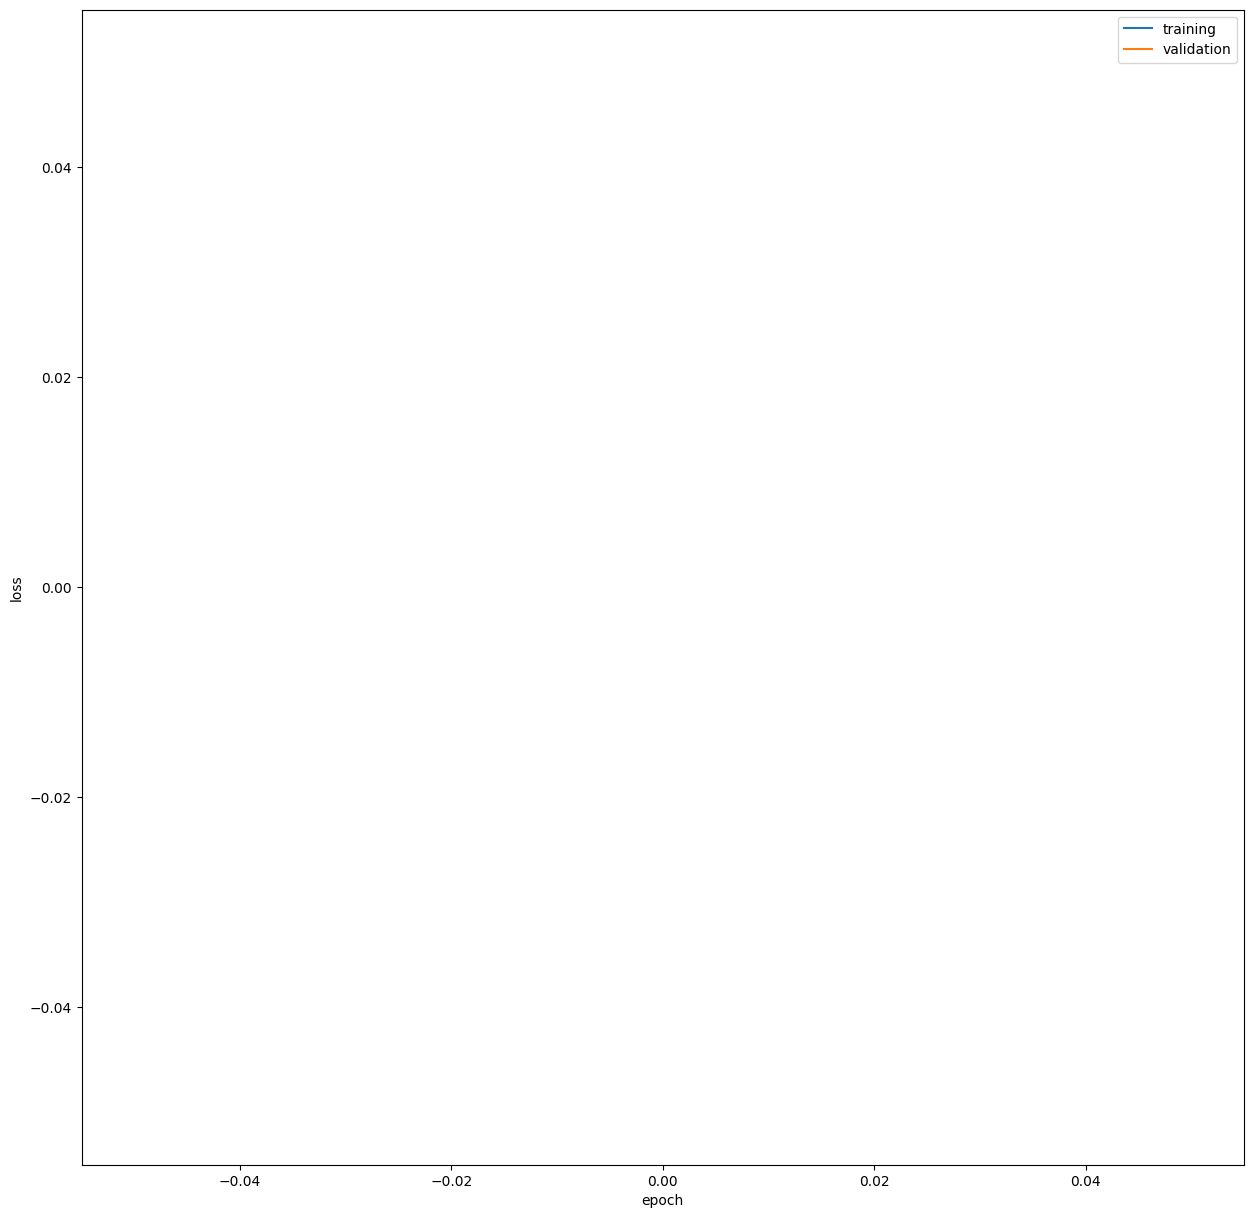

In [106]:
plt.figure(figsize=(15,15))
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

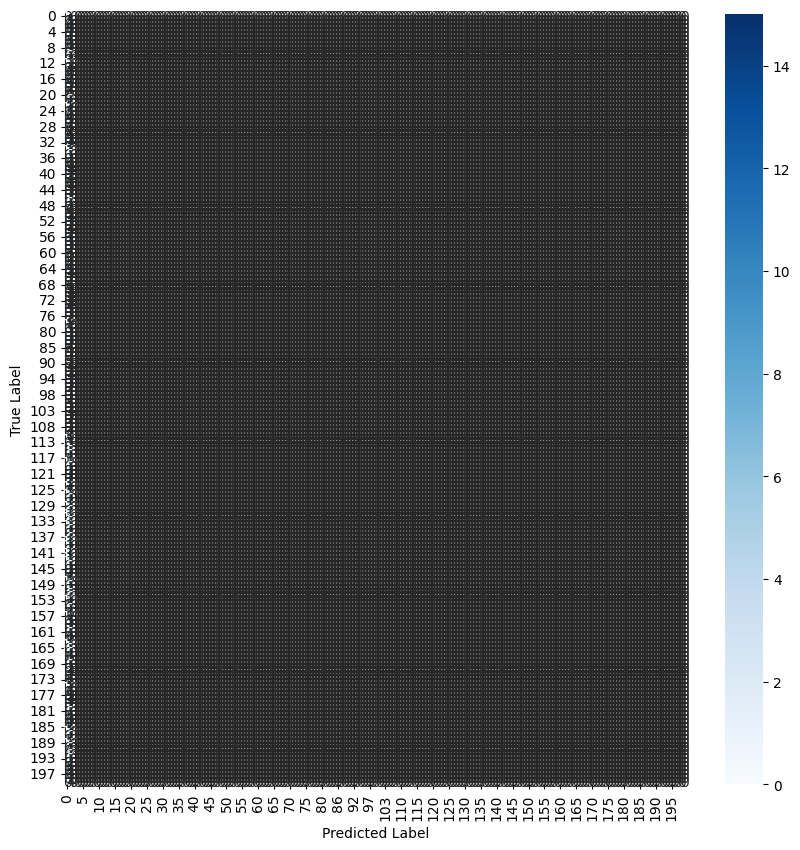

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

truelabels = []
predictions = []

model.eval()
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    truelabels.extend(target.cpu().numpy())
    outputs = model(data)
    preds = outputs.cpu().detach().numpy().argmax(1)
    predictions.extend(preds)

unique_labels = np.unique(truelabels + predictions)

cm = confusion_matrix(truelabels, predictions, labels=unique_labels)

df_cm = pd.DataFrame(cm, index=unique_labels, columns=unique_labels)
plt.figure(figsize=(10,10))
sns.heatmap(df_cm, annot=True, fmt='g', cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


## Adding attributes


In [1]:
# -------------------------
# 1. Dataset
# -------------------------
class BirdDataset(Dataset):
    def __init__(self, image_paths, labels, attributes, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.attributes = attributes
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label_idx = int(self.labels[idx]) - 1  # 0-based
        attr = torch.tensor(self.attributes[label_idx], dtype=torch.float32)
        return img, attr, label_idx

# -------------------------
# 2. Test Dataset met dummy attributes
# -------------------------
class BirdTestDataset(Dataset):
    def __init__(self, image_paths, num_attributes=312, transform=None):
        self.image_paths = image_paths
        self.num_attributes = num_attributes
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        attrs = torch.zeros(self.num_attributes, dtype=torch.float32)
        return img, attrs


train_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(128, scale=(0.8,1.0)),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

# -------------------------
# 4. Image paths + attributes + labels
# -------------------------
train_folder = 'resized_training_data'
attributes = np.random.rand(200, 312).astype(np.float32)  # vervang door echte attributes

image_paths = []
labels = []
for folder_name in sorted(os.listdir(train_folder), key=lambda x: int(x)):
    class_folder = os.path.join(train_folder, folder_name)
    for img_file in glob(os.path.join(class_folder, '*.jpg')):
        image_paths.append(img_file)
        labels.append(folder_name)

dataset = BirdDataset(image_paths, labels, attributes, transform=train_transform)

# Train/val split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# -------------------------
# 5. Model (multi-output)
# -------------------------
class SmallCNNWithAttributesMultiTask(nn.Module):
    def __init__(self, num_attributes=312, num_classes=200):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.AdaptiveAvgPool2d(1)
        )
        self.attr_fc = nn.Sequential(nn.Linear(num_attributes, 128), nn.ReLU())
        self.fc_class = nn.Sequential(nn.Linear(256+128, 256), nn.ReLU(), nn.Dropout(0.5), nn.Linear(256, num_classes))
        self.fc_attr = nn.Sequential(nn.Linear(256+128, 256), nn.ReLU(), nn.Dropout(0.5), nn.Linear(256, num_attributes))

    def forward(self, x_img, x_attr):
        x_feat = self.cnn(x_img)
        x_feat = x_feat.view(x_feat.size(0), -1)
        x_attr_emb = self.attr_fc(x_attr)
        x = torch.cat([x_feat, x_attr_emb], dim=1)
        return self.fc_class(x), self.fc_attr(x)

# -------------------------
# 6. Training setup
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallCNNWithAttributesMultiTask(num_attributes=312, num_classes=200).to(device)

criterion_class = nn.CrossEntropyLoss()
criterion_attr = nn.MSELoss()  # voor attributes
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

n_epochs = 30
best_acc = 0.0

# -------------------------
# 7. Training + validation loop
# -------------------------
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0

    for imgs, attrs, labels in train_loader:
        imgs, attrs, labels = imgs.to(device), attrs.to(device), labels.to(device)
        optimizer.zero_grad()
        pred_class, pred_attrs = model(imgs, attrs)
        loss1 = criterion_class(pred_class, labels)
        loss2 = criterion_attr(pred_attrs, attrs)
        total_loss = loss1 + 0.1 * loss2
        total_loss.backward()
        optimizer.step()
        running_loss += total_loss.item() * imgs.size(0)

    avg_train_loss = running_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for imgs, attrs, labels in val_loader:
            imgs, attrs, labels = imgs.to(device), attrs.to(device), labels.to(device)
            pred_class, pred_attrs = model(imgs, attrs)
            loss = criterion_class(pred_class, labels)
            val_loss += loss.item() * imgs.size(0)
            _, predicted = torch.max(pred_class, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_acc = 100.0 * correct / total
    avg_val_loss = val_loss / len(val_loader.dataset)

    scheduler.step(avg_val_loss)
    lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%, LR: {lr:.6f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print(f"Saved best model: {best_acc:.2f}%")


NameError: name 'Dataset' is not defined

In [117]:
from glob import glob
from torch.utils.data import DataLoader

test_image_paths = sorted(glob('test_images/test_images/*.jpg'))
test_dataset = BirdTestDataset(test_image_paths, num_attributes=312, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=16)

model.load_state_dict(torch.load("best_model.pth"))
model.to(device)
model.eval()

all_predictions = []
with torch.no_grad():
    for imgs, attrs in test_loader:
        imgs, attrs = imgs.to(device), attrs.to(device)
        pred_class, pred_attrs = model(imgs, attrs)
        _, predicted = torch.max(pred_class, 1)
        all_predictions.extend(predicted.cpu().numpy())

submission = pd.read_csv('test_images_sample.csv')
submission['label'] = [p + 1 for p in all_predictions]
submission.to_csv('submission.csv', index=False)
print("submission.csv saved")


C:\Users\Merlijne\AppData\Local\Temp\ipykernel_20032\942125504.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


submission.csv saved


In [112]:
import os
print(os.listdir('test_images')[:10])


['test_images']
